In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import g0

In [2]:
def load_report(path):
    return np.fromfile(path, sep = ' ').reshape((-1,7))

mjd_unixtimestamp_offset = 10587.5
seconds_in_day = 3600 * 24

def mjd2unixtimestamp(m):
    return (m - mjd_unixtimestamp_offset) * seconds_in_day

In [3]:
pre = load_report('orbit/phasing/Tianwen1_pre_phasing.txt')
post = load_report('orbit/phasing/Tianwen1_post_phasing.txt')[::-1]
t = np.datetime64('1970-01-01') + (mjd2unixtimestamp(pre[:,0]) * 1e9) * np.timedelta64(1, 'ns')

In [4]:
post_interp = np.empty_like(pre)
post_interp[:,0] = pre[:,0]
for j in range(1, post_interp.shape[1]):
    post_interp[:,j] = np.interp(post_interp[:,0], post[:,0], post[:,j], left = np.nan, right = np.nan)

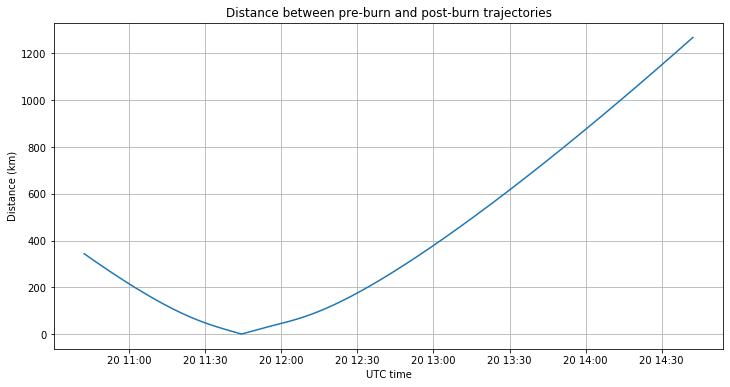

In [5]:
plt.figure(figsize = (12,6), facecolor = 'w')
dist = np.sqrt(np.sum((pre[:,1:4] - post_interp[:,1:4])**2, axis = 1))
plt.plot(t, dist)
plt.grid()
plt.title('Distance between pre-burn and post-burn trajectories')
plt.xlabel('UTC time')
plt.ylabel('Distance (km)');

In [6]:
sel = ~np.isnan(dist)
burn_idx = np.argmin(dist[sel])
t[sel][burn_idx]

numpy.datetime64('2021-02-20T11:44:17.567000064')

In [7]:
dist[sel][burn_idx]

0.6645047183238856

In [8]:
# Periapsis time
periapsis_idx = np.argmin(np.sqrt(np.sum((pre[sel,1:4])**2, axis = 1)))
t[sel][periapsis_idx]

numpy.datetime64('2021-02-20T11:46:41.567000320')

In [9]:
delta_v_ms = (post_interp[sel][burn_idx, 4:] - pre[sel][burn_idx, 4:]) * 1e3
delta_v_ms

array([-1.47673727, -1.91188349, 52.56519009])

In [10]:
delta_v_norm = np.sqrt(np.sum(delta_v_ms**2))
delta_v_norm

52.62067331740185

In [11]:
# Burn of 3 kN
ve = 321.6 * u.s * g0
F = 3e3 * u.N
m0 = (2500 + 950) * u.kg # estimate with 2500 kg dry mass and 950 kg fuel
T = (ve * m0 / F * (1 - np.exp(-delta_v_norm * u.m/u.s / ve))).to(u.s)
T

<Quantity 60.01174171 s>

In [12]:
mdot = -(F/ve).to(u.kg/u.s)
deltam = mdot * T
deltam

<Quantity -57.08483768 kg>

In [13]:
# VNB frame
r = pre[sel][burn_idx, 1:4]
v = pre[sel][burn_idx, 4:]
rr = r / np.sqrt(np.sum(r**2))
vv = v / np.sqrt(np.sum(v**2))
n = np.cross(rr, vv)
n /= np.sqrt(np.sum(n**2))
b = np.cross(vv, n)
U = np.matrix([vv, n, b]).T

In [14]:
# Delta-V in [r/|r|, v_u/|v_u|, N] frame
U.T @ delta_v_ms

matrix([[-5.04062932e+01,  3.22691744e-02,  1.51042983e+01]])